# Exploring the UTx000 Extension Beacon Data
(Known as BPEACE2 in the [GH repo](https://github.com/intelligent-environments-lab/utx000))

# Summary
This notebook helps look at the measurements taken during the study period for the various sensors on the beacons.

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Package Import

In [2]:
import sys
sys.path.append('../')

from src.features import build_features
from src.visualization import visualize
from src.reports import make_report

import pandas as pd
import numpy as np
import scipy

from datetime import datetime, timedelta

# Data Import

In [62]:
beacon_data = pd.read_csv('../data/processed/bpeace2-beacon.csv',index_col=0,parse_dates=True)
# show it off:
beacon_data.head()

,TVOC,eCO2,Lux,Visible,Infrared,NO2,T_NO2,RH_NO2,CO,T_CO,...,PM_N_4,PM_N_10,PM_C_1,PM_C_2p5,PM_C_4,PM_C_10,Beacon,Beiwe,Fitbit,REDCap
Timestamp,,,,,,,,,,,,,,,,,,,,,
2020-06-14 09:00:00,259.28,578.44,NaN,5242.8,0.08,72.00,28.00,39.00,0.0,27.0,...,75.085150,75.255575,9.341261,14.640621,18.495087,19.265980,1,kyj367pi,24,10
2020-06-14 09:05:00,254.72,567.24,NaN,7864.2,0.12,70.40,28.00,38.20,0.0,27.0,...,66.893462,67.078398,8.308624,14.025957,18.266718,19.114872,1,kyj367pi,24,10
2020-06-14 09:10:00,253.44,556.08,NaN,5242.8,0.08,70.60,27.76,38.00,0.0,27.0,...,63.810522,64.021259,7.911684,14.398427,19.280350,20.256734,1,kyj367pi,24,10
2020-06-14 09:15:00,251.70,555.30,NaN,6553.5,0.10,69.25,27.45,38.75,0.0,27.0,...,62.390107,62.542123,7.757636,12.474105,15.930472,16.621745,1,kyj367pi,24,10
2020-06-14 09:20:00,256.44,563.04,0.0,0.0,0.00,70.76,28.00,39.00,0.0,27.0,...,63.738248,63.905140,7.920531,13.087709,16.901268,17.663979,1,kyj367pi,24,10


We also need some important information regarding shipment dates to calculate completeness. So we import the beacon-specific ```id_crossover``` file.

In [26]:
details = pd.read_excel('../data/raw/bpeace2/admin/id_crossover.xlsx',sheet_name='beacon',index_col=1,
                       parse_dates=['start_date','end_date','move_date'],infer_datetime_format=True)
details.head()

,REDCap,Beacon,start_date,end_date,move_date,return_date,Lat,Long,Original Address,Volume,Housemates,Roommates,Number of Rooms,original_start,original_end,original_move
Beiwe,,,,,,,,,,,,,,,,
kyj367pi,10,1,2020-06-08 13:00:00,2020-09-03,2020-07-31,2020-09-02,30.312614,-97.732338,"2822 Rio Grande St. Apt 202 Austin, TX, 78705",1080,0,0,1.0,2020-06-15,NaT,2020-09-14
745vq78e,55,5,2020-06-09 10:21:00,2020-08-23,NaT,2020-09-08,30.288012,-97.751201,"18207 Branson Falls San Antonio, TX 78255",1188,0,0,5.0,2020-06-15,NaT,2020-08-17
itmylz3g,61,6,2020-06-17 14:08:00,2020-09-01,NaT,2020-09-01,29.855371,-95.741200,"5403 Dunsmore Harbor Ln, Katy, TX 77449",1188,0,0,5.0,2020-06-15,2020-09-11,2020-07-03
zdpffrox,0,7,2020-06-01 00:00:00,2020-09-01,NaT,2020-09-01,30.326815,-97.744665,"2211 Lawnmont Avenue apt 314 Austin, TX 78756",1365,1,1,NaN,2020-06-06,2020-09-03,2020-07-31
xlw5ntd5,43,10,2020-06-08 13:19:00,2020-09-11,2020-08-10,2020-09-22,30.351693,-97.614524,"6704 bramber ln, austin, tx 78754",1188,0,0,NaN,2020-06-08,NaT,2020-07-01


# Base Analysis
Here we look at the raw, unaltered data in order to understand:
- what data are available? (see 4.1.1 notebook to see when participants actually measured data)
- how much data were collected?
- what are typical measurements and what does this say?
- are there any misbehaving sensors?

In [5]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from matplotlib.colors import LogNorm

## What data are available?
Here we look at some basic visualizations to get a sense of the data collected

### Heatmaps by Sensor
These heatmaps show the values measured by a specific sensor on all of the beacons, but are more useful for determining when data are available.

Working for PM_C_2p5
	Data collected
	Plotting


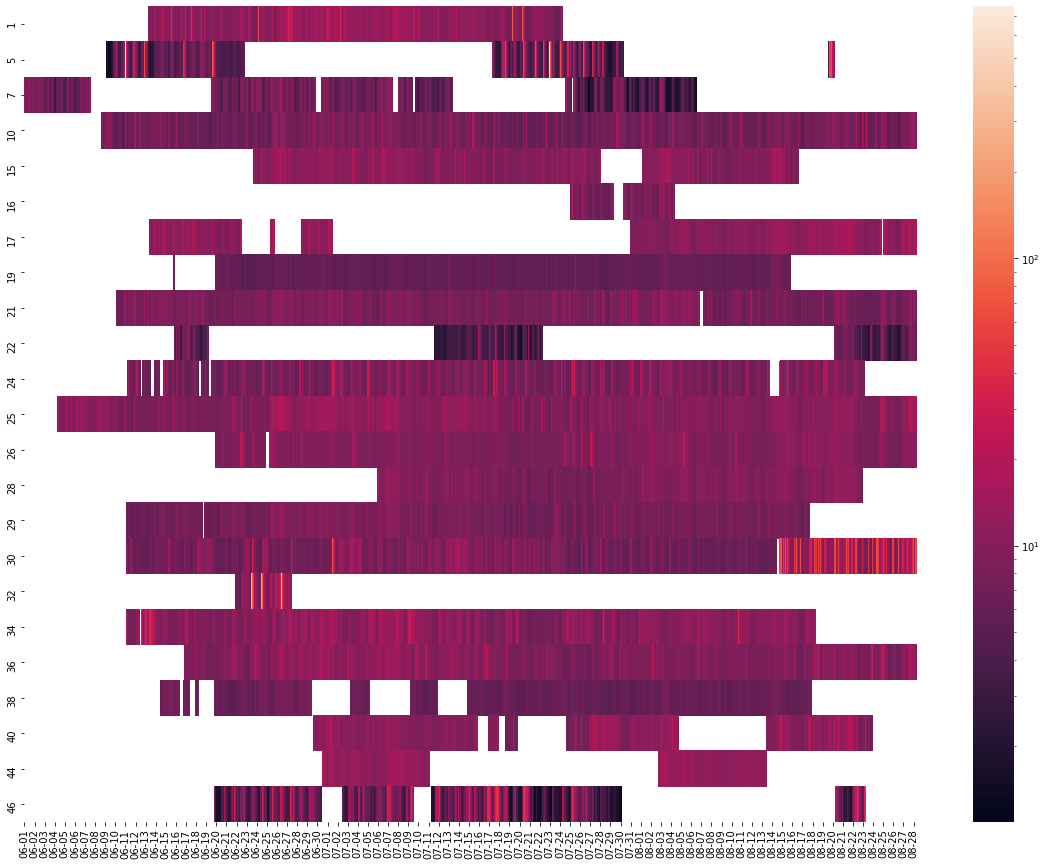

Working for CO2
	Data collected
	Plotting


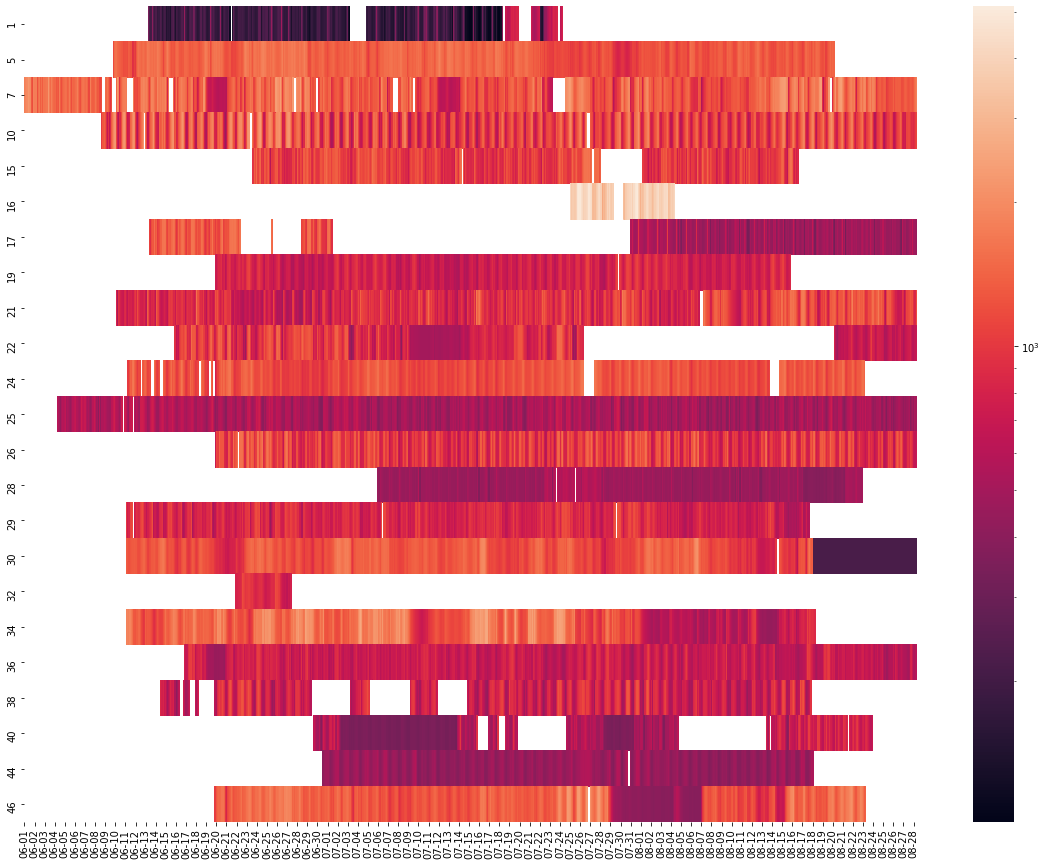

Working for CO
	Data collected
	Plotting


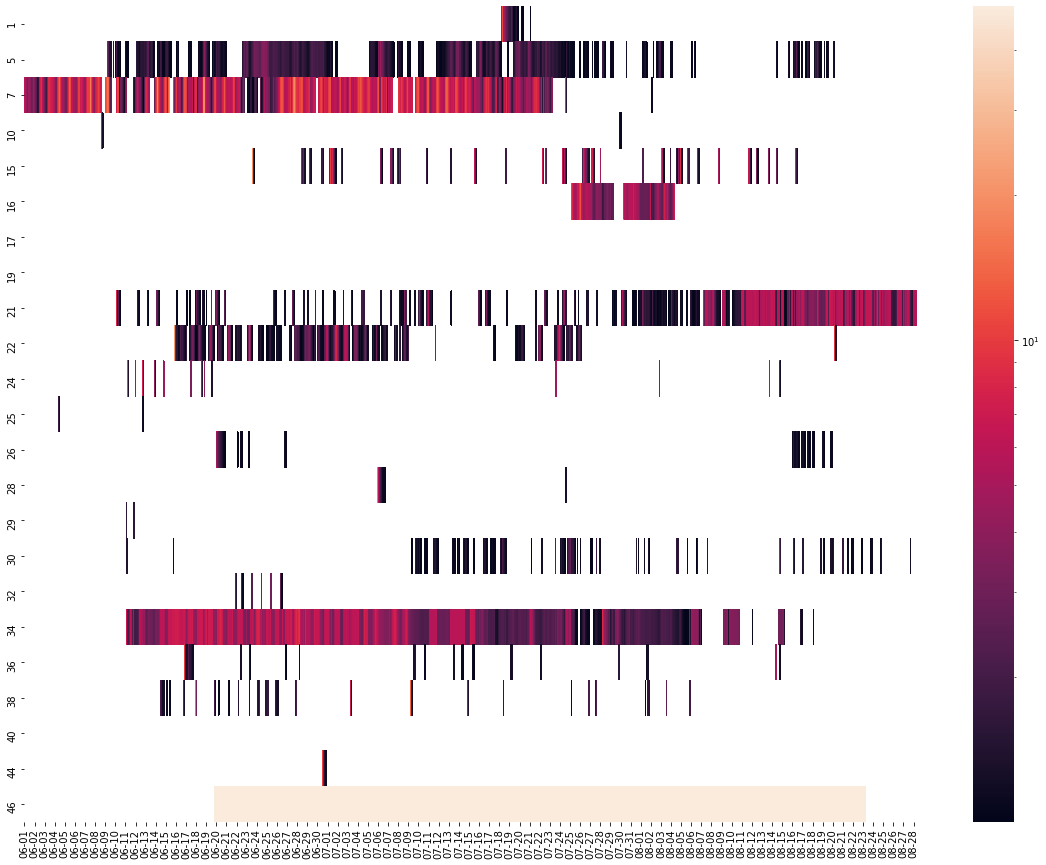

Working for NO2
	Data collected
	Plotting


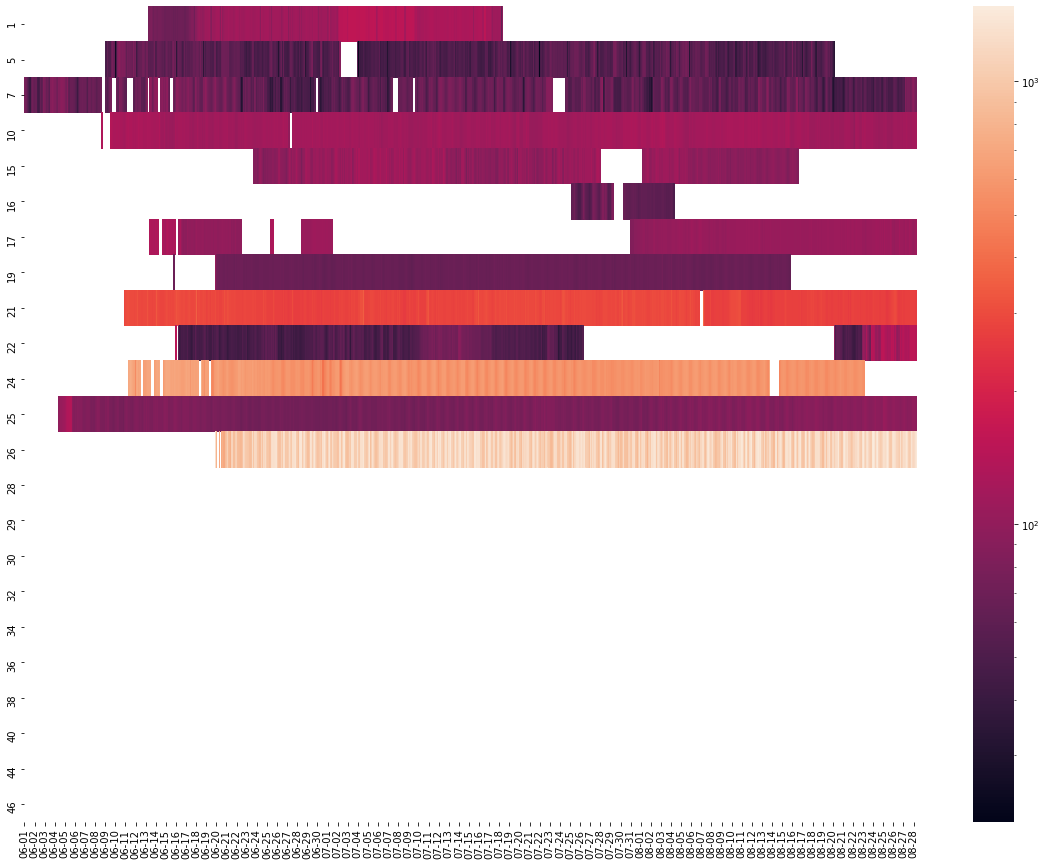

Working for T_NO2
	Data collected
	Plotting


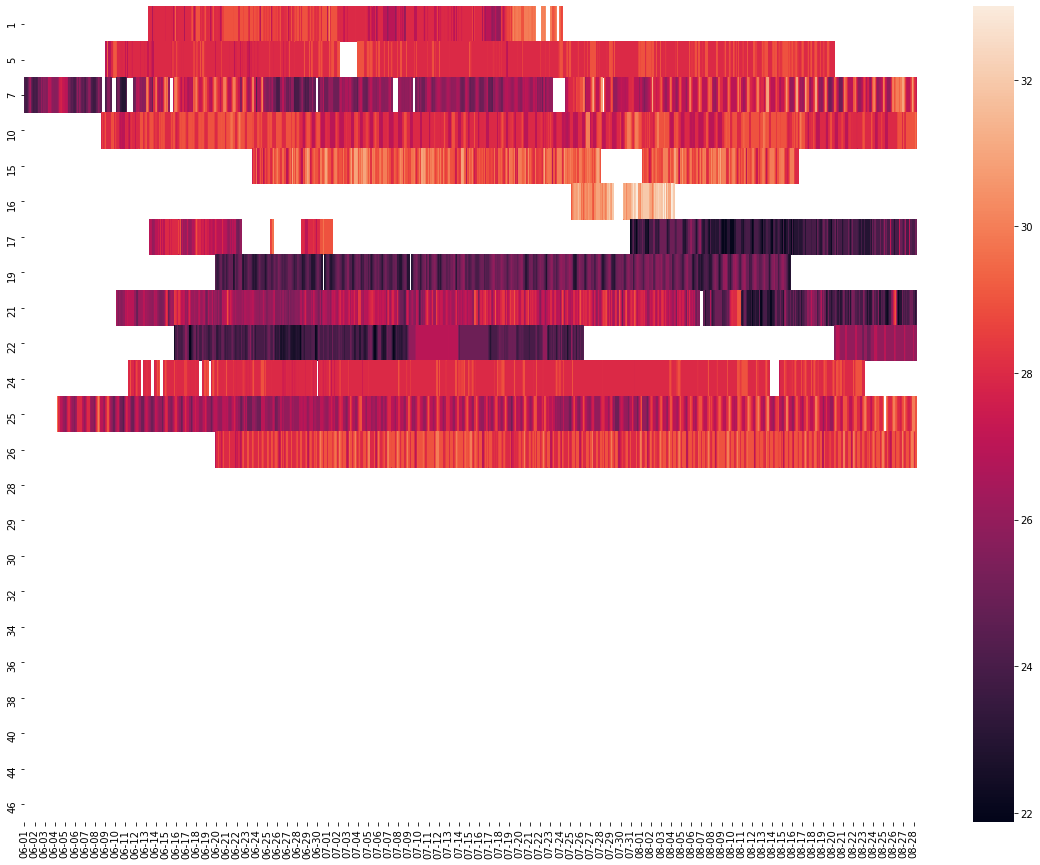

Working for Lux
	Data collected
	Plotting


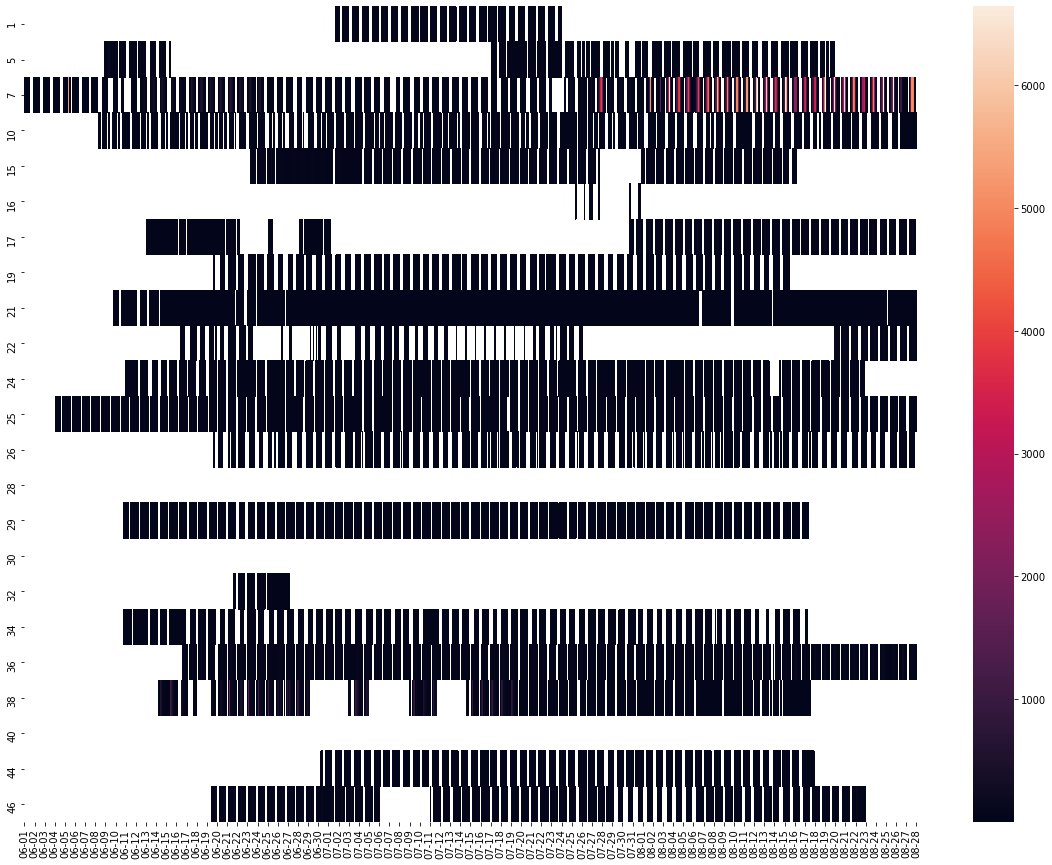

In [6]:
var_list = ['PM_C_2p5','CO2','CO','NO2','T_NO2','Lux']
limit_list = [[1,75],[1,2000],[1,20],[1,100],[1,50],[0,600000]]
for variable, limits in zip(var_list, limit_list):
    print(f'Working for {variable}')
    heatmap_df = pd.DataFrame()
    for beacon in beacon_data['Beacon'].unique():
        data_by_beacon = beacon_data[beacon_data['Beacon'] == beacon]
        data_by_beacon = data_by_beacon[data_by_beacon[variable] > 1]
        data_by_beacon = data_by_beacon.resample('1h').mean()
        sdate = datetime(2020,6,1)
        edate = datetime(2020,9,1)
        data_by_beacon = data_by_beacon[sdate:edate]
        heatmap_df = pd.concat([heatmap_df,data_by_beacon[variable]],axis=1)
        heatmap_df.rename(columns={variable:beacon}, inplace=True)

    print(f'\tData collected')
    fig, ax = plt.subplots(figsize=(20,15))
    df_to_plot = heatmap_df.T
    print(f'\tPlotting')
    if variable[0] in ['T','L']:
        sns.heatmap(df_to_plot,vmin=np.nanmin(df_to_plot),vmax=np.nanmax(df_to_plot))
    else:
        sns.heatmap(df_to_plot,norm=LogNorm(vmin=np.nanmin(df_to_plot),vmax=np.nanmax(df_to_plot)))
        
    x_labels = []
    for d in pd.date_range(sdate,edate-timedelta(days=1),freq='d'):
        x_labels.append(d.strftime('%m-%d'))
        
    ax.set_xticklabels(x_labels)
    
    plt.show()
    plt.close()

### Time Series Sensor Operation
Now we show individual beacons as a simplified time series to see that the sensors were operating.

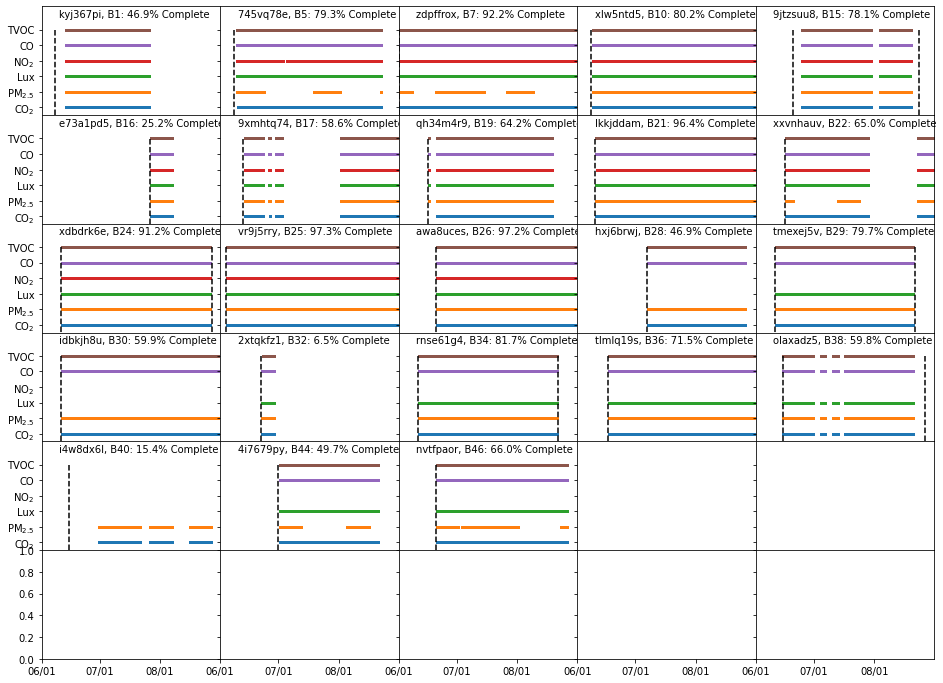

In [7]:
fig, axes = plt.subplots(6,5,figsize=(16,12),sharex=True,sharey='row')
rows = [0,0,0,0,0,1,1,1,1,1,2,2,2,2,2,3,3,3,3,3,4,4,4,4,4,5,5,5,5,5]
cols = [0,1,2,3,4]*6
sensors = ['CO2','PM_C_2p5','Lux','NO2','CO','TVOC']
sensor_datapoints_dict = {'CO2':0,'PM_C_2p5':0,'Lux':0,'NO2':0,'CO':0,'TVOC':0}
for beiwe, r, c in zip(beacon_data['Beiwe'].unique(),rows,cols):
    # restricting to participant
    beacon_by_beiwe = beacon_data[beacon_data['Beiwe'] == beiwe]
    beacon_by_beiwe = beacon_by_beiwe[details.loc[beiwe,'start_date']:details.loc[beiwe,'end_date']]
    beacon = beacon_by_beiwe['Beacon'][0]
    limits = [-50,0,-10,-1000,-1000,-50]
    # Getting overall percentage of data completion
    total_datapoints = (details.loc[beiwe,'return_date'] - details.loc[beiwe,'start_date'] + timedelta(days=1)).days
    # x24 x60 to get into minutes, /5 for interverals, x6 for number of sensors
    total_datapoints = total_datapoints * 24 * 60 / 5 * len(sensors)
    available_datapoints = 0
    for sensor in sensors:
        available_datapoints += np.count_nonzero(~np.isnan(beacon_by_beiwe[sensor]))
        sensor_datapoints_dict[sensor] += np.count_nonzero(~np.isnan(beacon_by_beiwe[sensor]))
    total_percent = round(available_datapoints / total_datapoints * 100,1)
    
    i = 1
    ax = axes[r,c]
    for sensor, limit in zip(sensors,limits):
        beacon_by_beiwe[f'{sensor}_op'] = np.select([pd.to_numeric(beacon_by_beiwe[sensor],errors='coerce') > limit],[i])
        ax.scatter(beacon_by_beiwe.index,beacon_by_beiwe[f'{sensor}_op'],s=5,marker='s')
        i += 1
    # plotting start and stop dates
    ax.plot([details.loc[beiwe,'start_date'],details.loc[beiwe,'start_date']],[0,6],color='black',linestyle='dashed')
    ax.plot([details.loc[beiwe,'return_date']+timedelta(days=1),details.loc[beiwe,'return_date']+timedelta(days=1)],[0,6],color='black',linestyle='dashed')
    ax.text(datetime(2020,6,10),7,f'{beiwe}, B{beacon}: {total_percent}% Complete',va='center',ha='left')
    ax.set_ylim([0.5,7.5])
    ax.set_xlim([datetime(2020,6,1),datetime(2020,9,1)])
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[6,7,8]))
    ax.set_yticks(np.arange(1,7,1))
    ax.set_yticklabels(['CO$_2$','PM$_{2.5}$','Lux','NO$_2$','CO','TVOC'])
    
plt.subplots_adjust(hspace=0,wspace=0)
plt.savefig('../reports/utx000_initial_update/figures/time-beacon-sensor-operation-comprehensive.pdf')
plt.show()
plt.close()

### Heatmap per beacon
Now we can look at individual beacons and see how well they recorded during a specific time period. 

In [8]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

def create_cmap(colors,nodes):
    cmap = LinearSegmentedColormap.from_list("mycmap", list(zip(nodes, colors)))
    return cmap

<div class="alert alert-block alert-success">
    We are looking for a good summary of a week's worth of data. Looks:
    <ul>
        <li>week of July 6 is a good place to start</li>
        <li>Beacon 19</li>
    </ul>
    </div>

1:


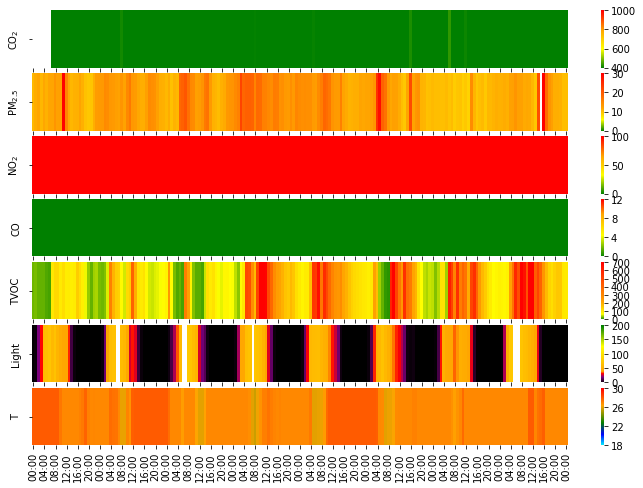

5:


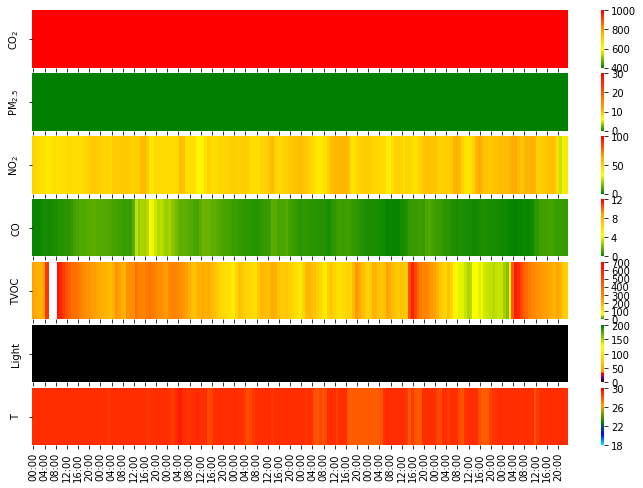

7:


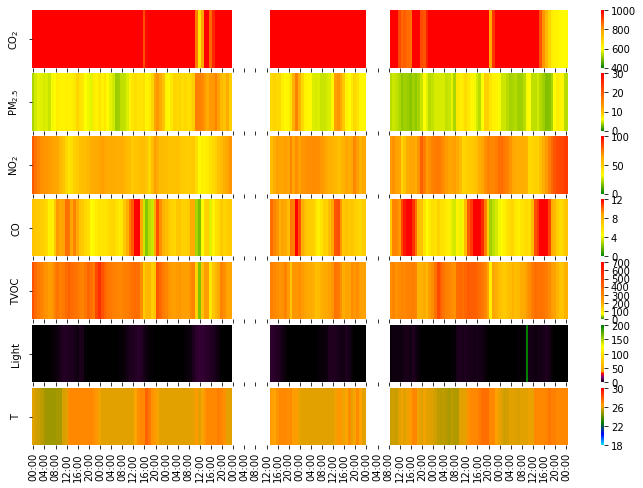

10:


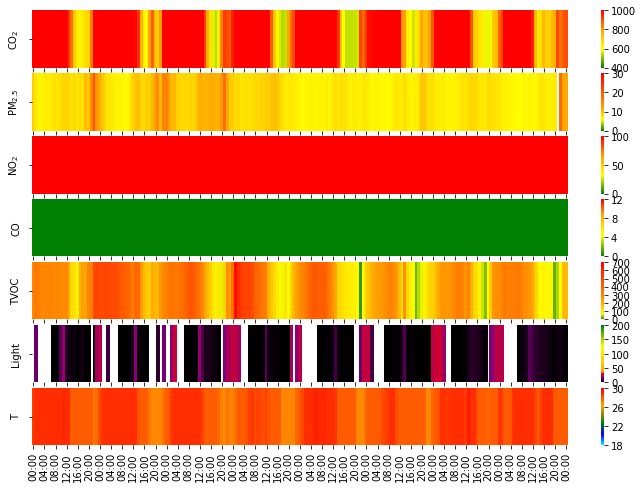

15:


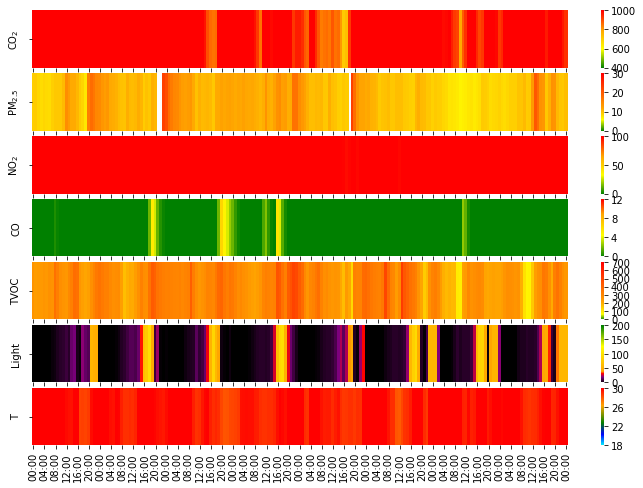

17:


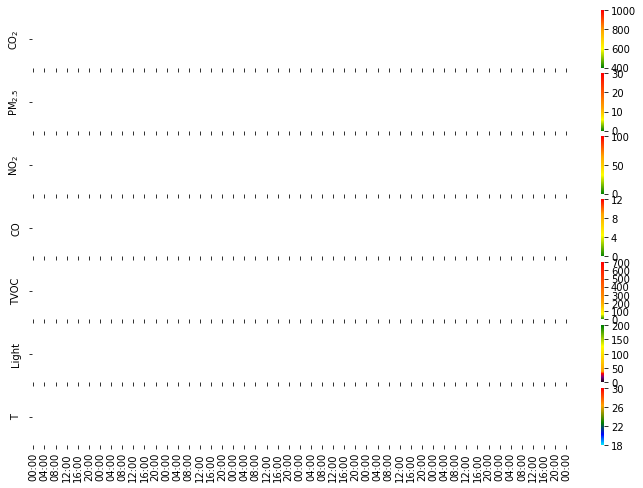

19:


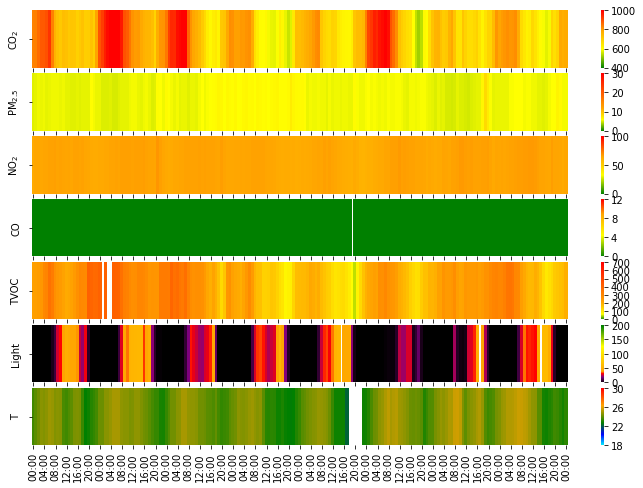

21:


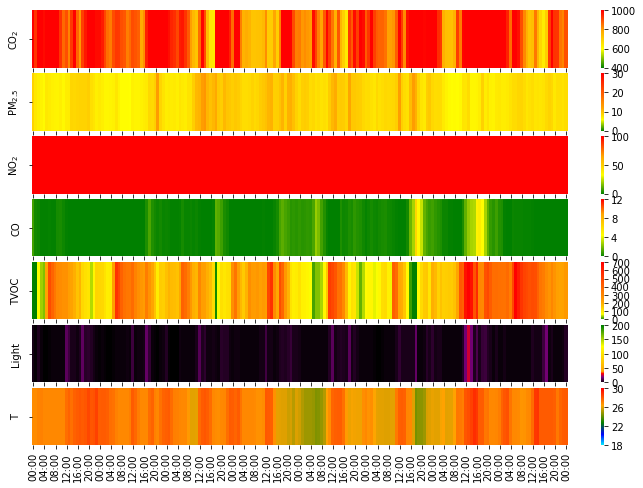

22:


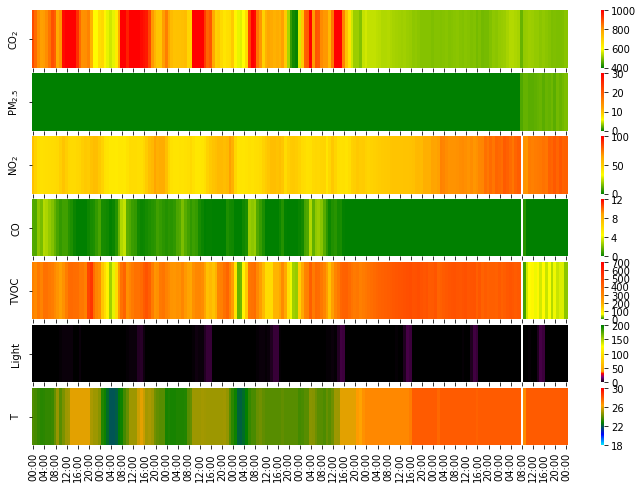

24:


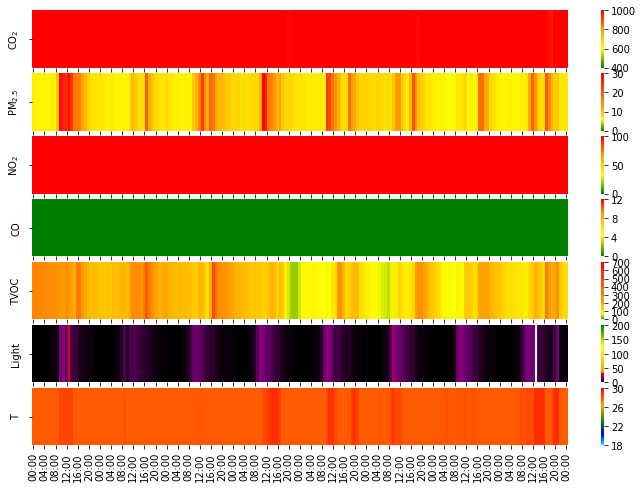

25:


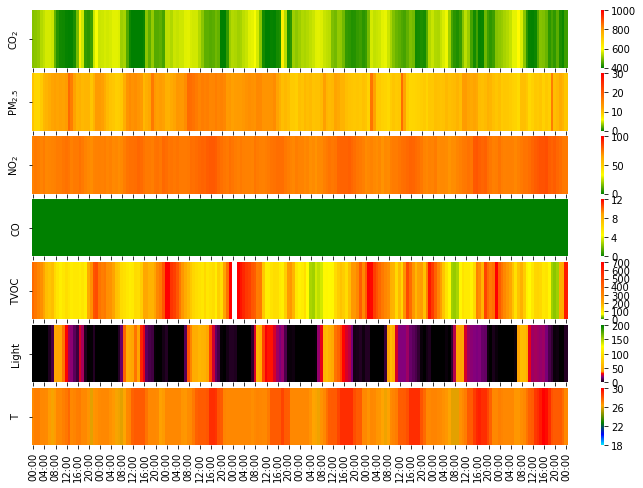

26:


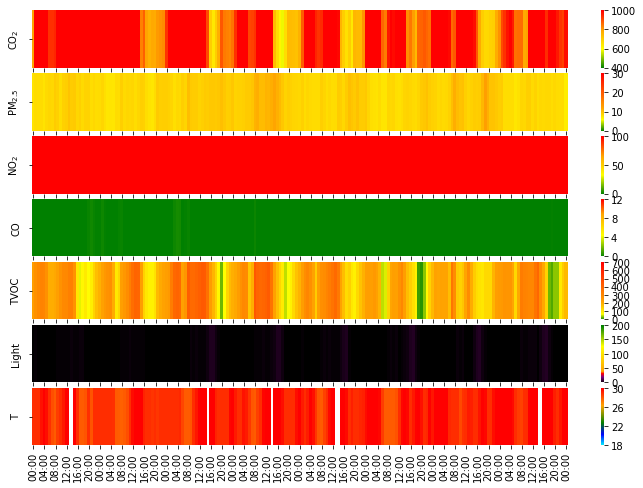

28:


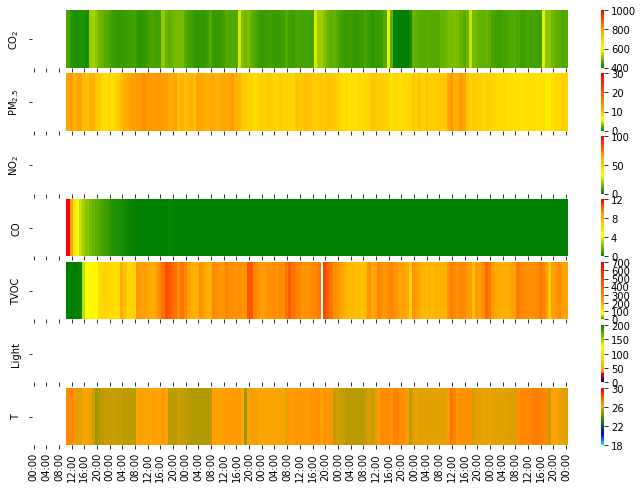

29:


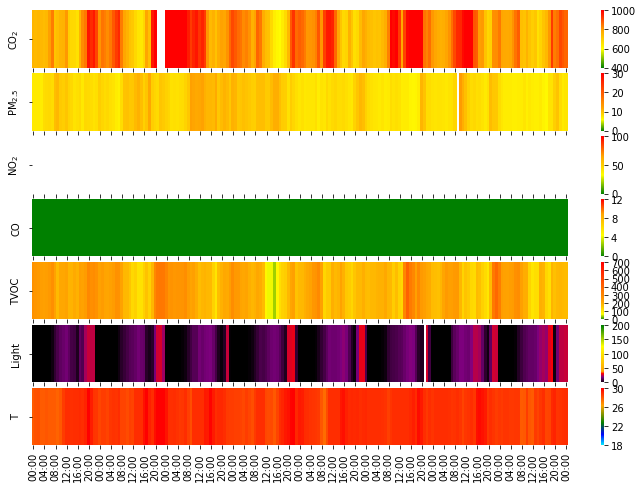

30:


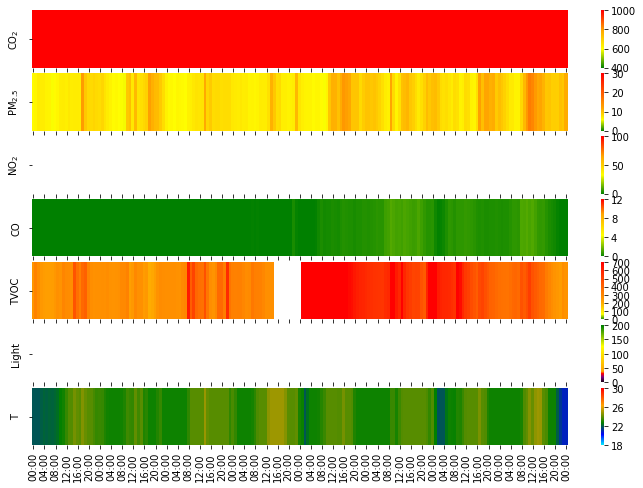

34:


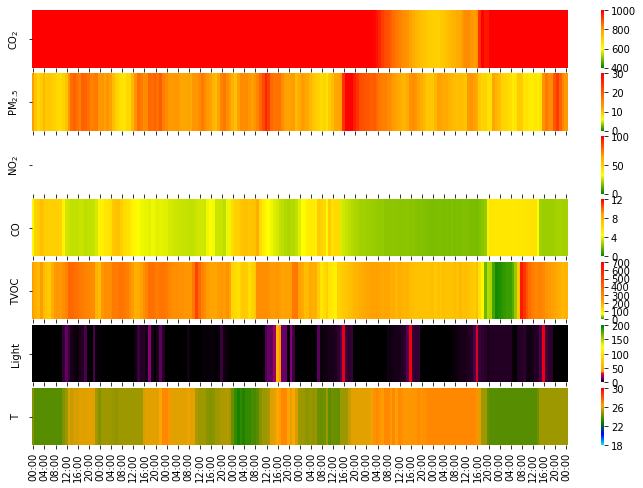

36:


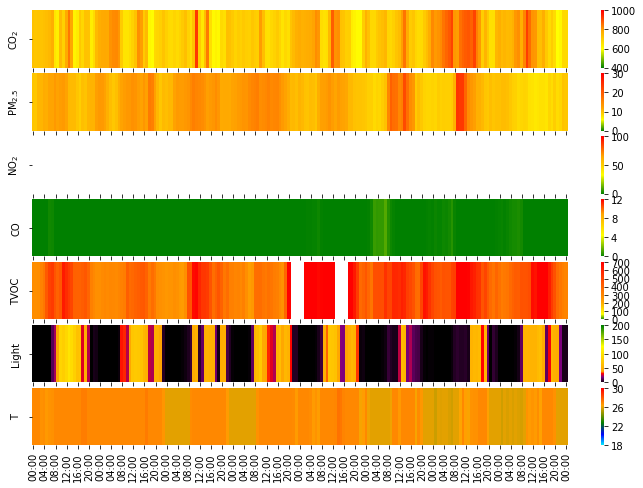

38:


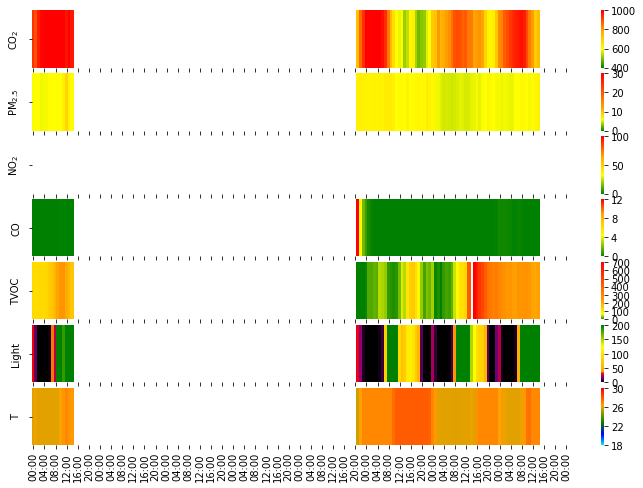

40:


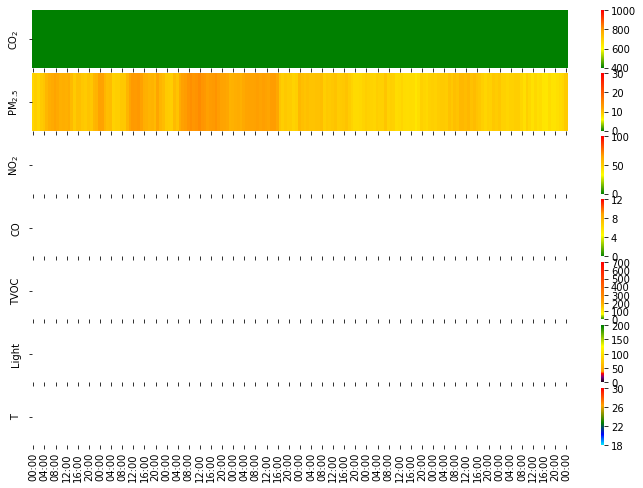

44:


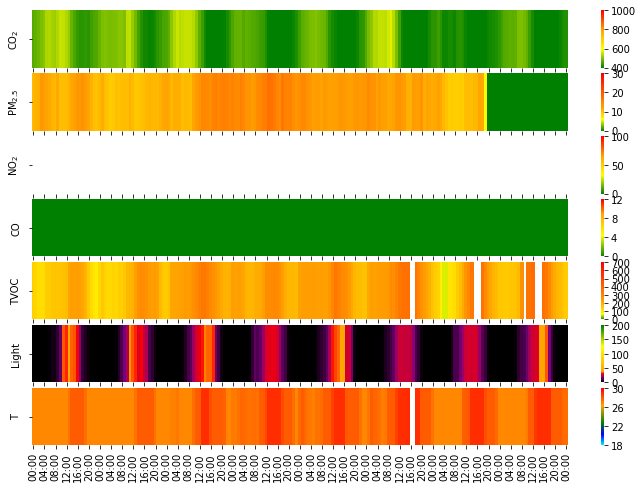

46:


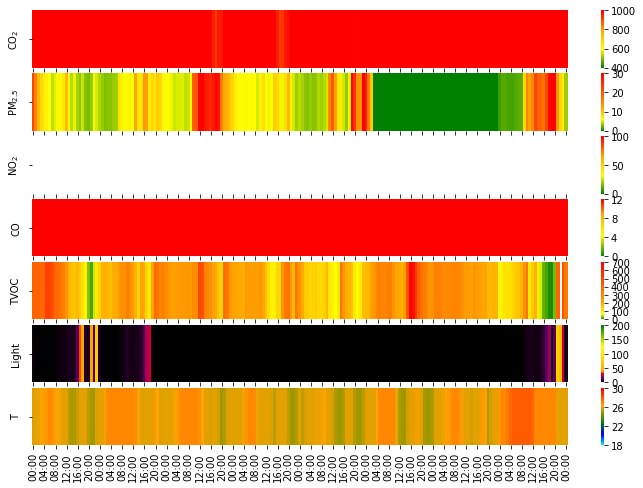

In [9]:
for bb in beacon_data['Beacon'].unique():
    beacon_bb = beacon_data[beacon_data['Beacon'] == bb][datetime(2020,7,6):datetime(2020,7,14)]
    if len(beacon_bb['NO2']) > 10:
        print(f'{bb}:')
        beacon_bb = beacon_bb.resample('60T').mean()
        beacon_bb_pollutants = beacon_bb[['CO2','PM_C_2p5','NO2','CO','TVOC','Lux','T_CO']]
        fig, axes = plt.subplots(7,1,figsize=(12,8),sharex=True)
        ylabels = ['CO$_2$',
                   'PM$_{2.5}$',
                   'NO$_2$',
                   'CO',
                   'TVOC',
                   'Light',
                   'T']
        cbar_ticks = [np.arange(400,1200,200),
                      np.arange(0,40,10),
                      np.arange(0,120,50),
                      np.arange(0,15,4),
                      np.arange(0,800,100),
                      np.arange(0,250,50),
                      np.arange(18,32,4)]
        cmaps = [create_cmap(["green", "yellow", "orange", "red",],[0.0, 0.33, 0.66, 1]),
                 create_cmap(["green", "yellow", "orange", "red"],[0.0, 0.2, 0.4, 1]),
                 create_cmap(["green", "yellow", "orange", "red"],[0.0, 0.33, 0.66, 1]),
                 create_cmap(["green", "yellow", "orange", "red"],[0.0, 0.375, 0.75, 1]),
                 create_cmap(["green", "yellow", "orange", "red"],[0.0, 0.1, 0.31, 1]),
                 create_cmap(["black","purple","red","orange","yellow","green"],[0.0, 0.1, 0.16, 0.2, 0.64, 1]),
                 create_cmap(["cyan","blue","green","orange","red"],[0.0, 0.2, 0.4, 0.7, 1])]
        for ax, var, low, high, ylabel, ticks, cmap in zip(axes,beacon_bb_pollutants.columns,[400,0,0,0,0,0,18],[1000,30,100,12,700,200,30],ylabels,cbar_ticks,cmaps):
            sns.heatmap(beacon_bb_pollutants[[var]].T,vmin=low,vmax=high,ax=ax,cbar_kws={'ticks':ticks},cmap=cmap)
            ax.set_ylabel(ylabel)
            ax.set_yticklabels([''])
            ax.set_xlabel('')

        xlabels = ax.get_xticklabels()
        new_xlabels = []
        for label in xlabels:
            new_xlabels.append(label.get_text()[11:16])

        ax.set_xticklabels(new_xlabels)
        plt.subplots_adjust(hspace=0.1)
        plt.savefig('../reports/BuildSys2020/beacon_example.pdf')
        plt.show()
        plt.close()

### Time Series per Beacon
Well, just checking a few.

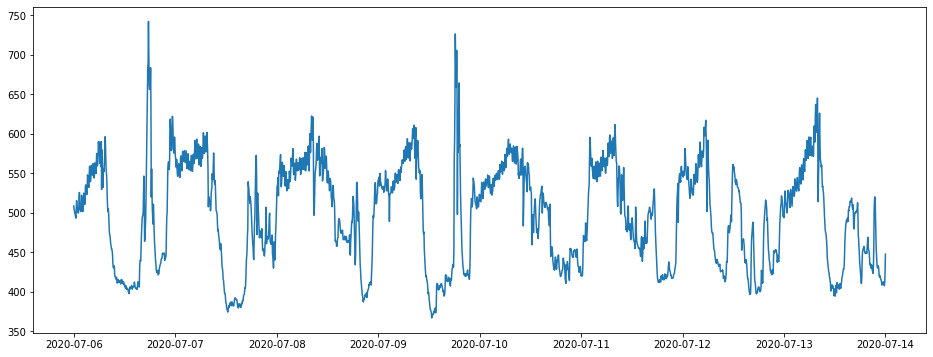

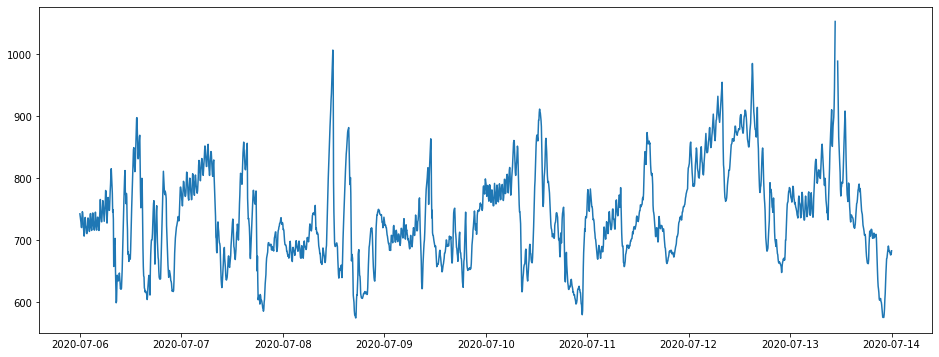

In [10]:
for bb in [25,36]:
    beacon_bb = beacon_data[beacon_data['Beacon'] == bb][datetime(2020,7,6):datetime(2020,7,14)]
    fig, ax = plt.subplots(figsize=(16,6))
    ax.plot(beacon_bb.index,beacon_bb['CO2'])

## How much data were collected?
Given the study period, we want to know how much of the possible data were collected

### Number of Hours
A nice metric would to be to see how many hours of data were collected. 

The number of hours is calculated as the sum of the hours each sensor on each beacon was operational.

In [11]:
# Getting number of datapoints
n_datapoints = 0
for sensor in ['TVOC','Lux','NO2','CO','CO2','PM_C_2p5']:
    data_per_sensor = beacon_data.loc[:,sensor]
    data_per_sensor.dropna(inplace=True)
    if sensor in ['NO2','CO']:
        t = len(beacon_data.loc[:,f'T_{sensor}'].dropna())
        rh = len(beacon_data.loc[:,f'RH_{sensor}'].dropna())
        print('Comparing DGS sensor readings:')
        print(f'\tT: {t}')
        print(f'\tRH: {rh}')
        print(f'\t{sensor}: {len(data_per_sensor)}')
        n_datapoints += max([t,rh,len(data_per_sensor)])
    else:
        print(f'{sensor}: {len(data_per_sensor)}')
        n_datapoints += len(data_per_sensor)
        
# datapoints are collected every five minutes, so we multiply the number of datapoints by 5 to get the minutes
n_hours = n_datapoints * 5 / 60
print(f'Number of hours of data collected: {n_hours}')
print(f'Number of days of data collected: {n_hours / 24}')

TVOC: 401985
Lux: 343459
Comparing DGS sensor readings:
	T: 246536
	RH: 247269
	NO2: 246794
Comparing DGS sensor readings:
	T: 402391
	RH: 404500
	CO: 407114
CO2: 411718
PM_C_2p5: 413411
Number of hours of data collected: 185413.0
Number of days of data collected: 7725.541666666667


In [12]:
total_sensor_datapoints = total_datapoints / len(sensors) * len(beacon_data['Beiwe'].unique())
total_no2_datapoints = total_datapoints / len(sensors) * 13
for key in sensor_datapoints_dict.keys():
    if key == 'NO2':
        percentage_complete = round(sensor_datapoints_dict[key] / total_no2_datapoints * 100,1)
    else:
        percentage_complete = round(sensor_datapoints_dict[key] / total_sensor_datapoints * 100,1)
    print(f'{key}: {percentage_complete}')

CO2: 74.9
PM_C_2p5: 75.2
Lux: 62.4
NO2: 79.4
CO: 74.0
TVOC: 73.1


## What are typical measurements?

### Histograms
These plots help show typical measurements by the sensors which we can use to refine our raw values

#### Raw Data
Here we summarize the distributions of values for the raw data. This helps us see what values we are measuring.

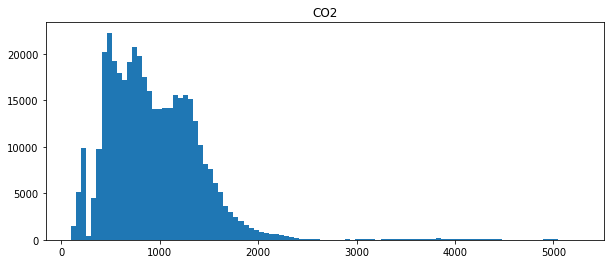

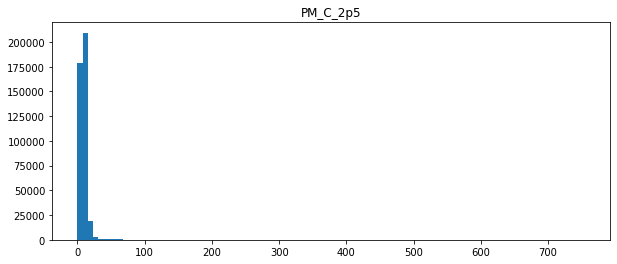

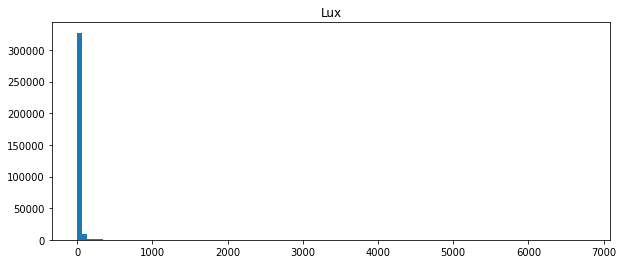

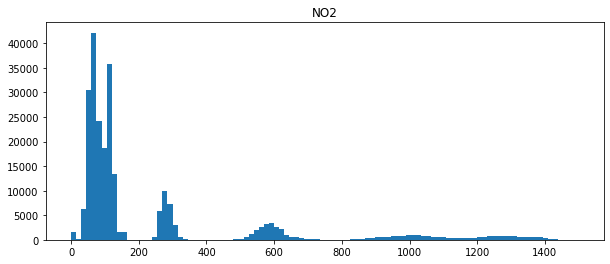

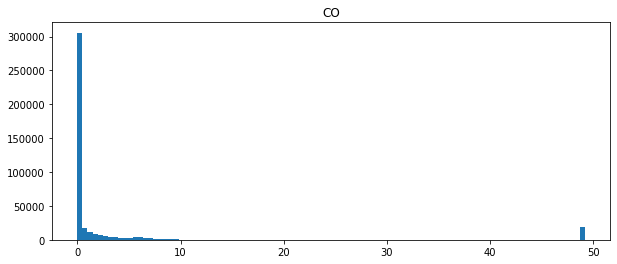

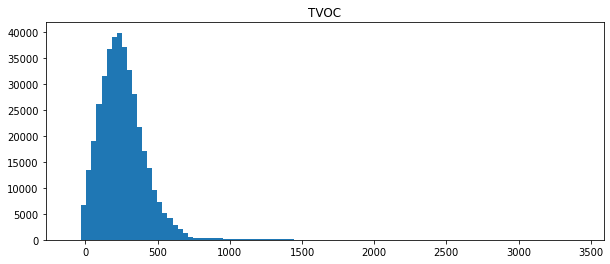

In [13]:
for pollutant in sensors:
    fig, ax = plt.subplots(figsize=(10,4))
    ax.hist(beacon_data[pollutant],bins=100)
    ax.set_title(pollutant)

Perhaps a certain participant has bad values, now we check the distributions of all the beacons still considering the raw values.

CO2


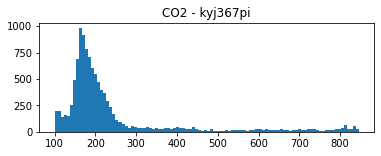

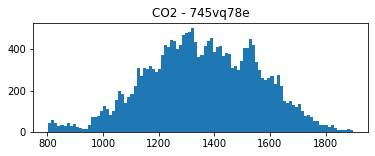

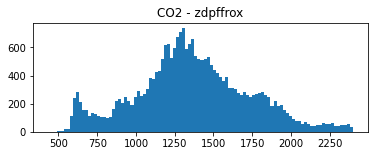

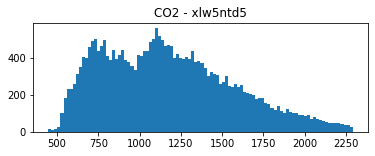

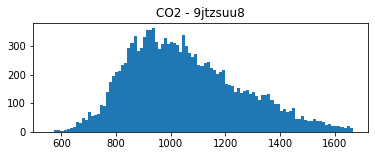

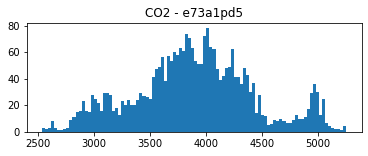

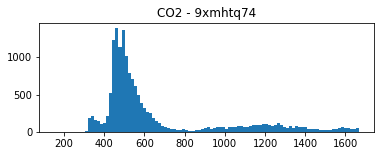

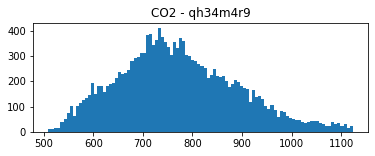

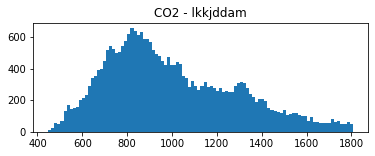

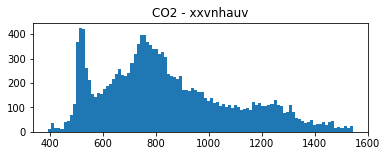

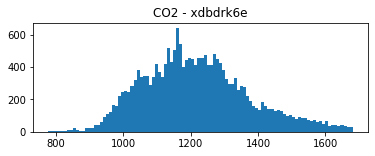

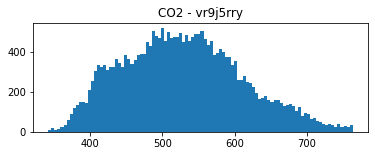

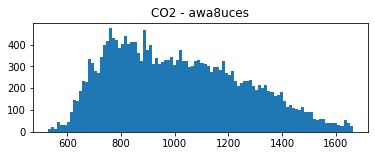

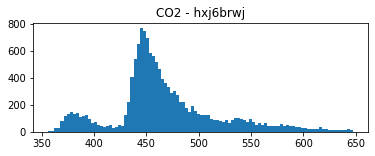

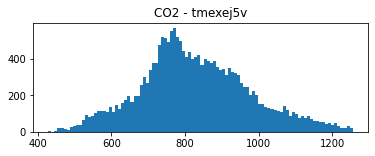

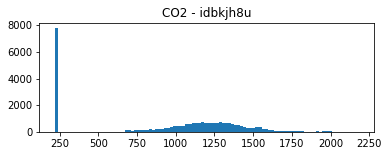

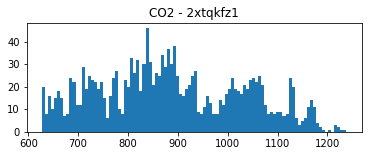

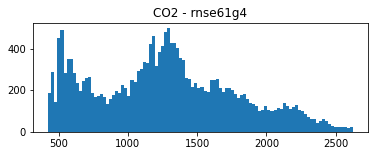

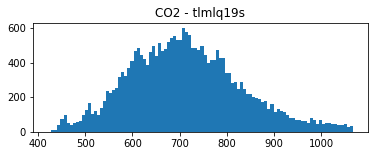

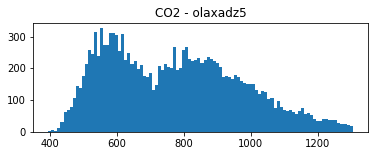

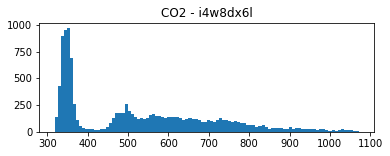

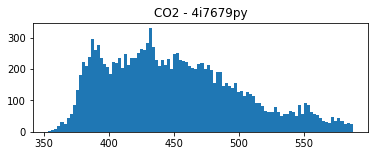

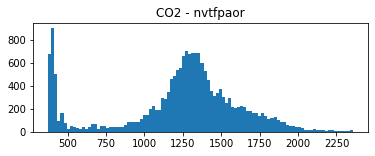

PM_C_2p5


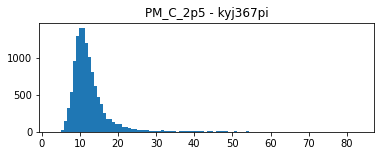

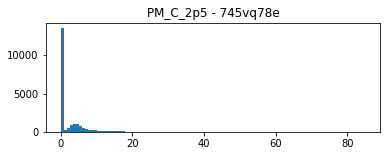

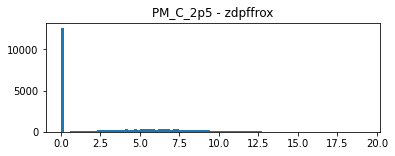

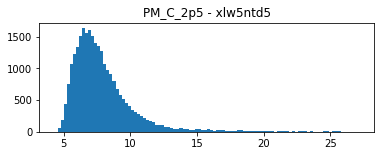

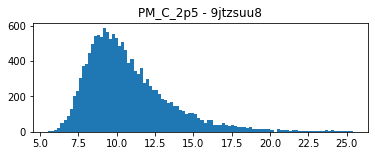

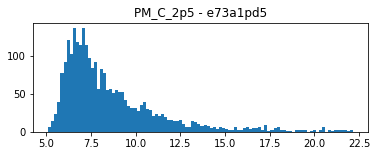

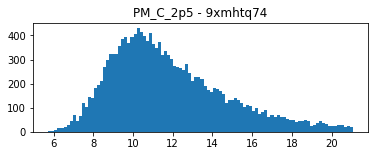

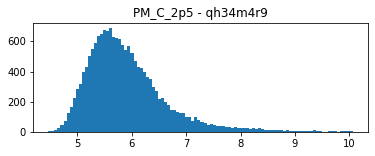

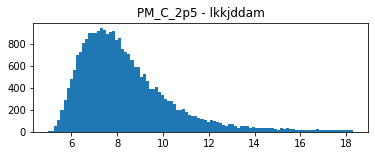

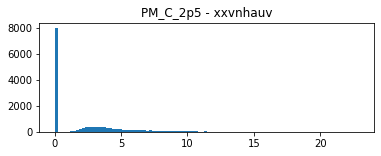

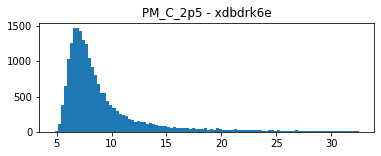

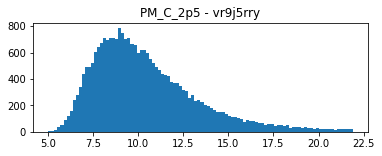

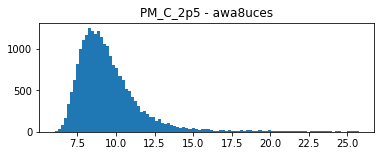

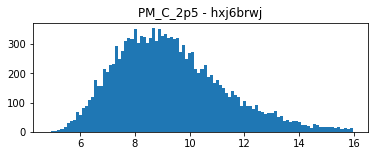

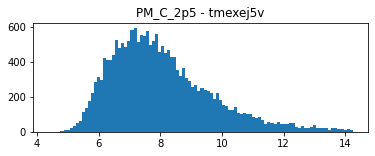

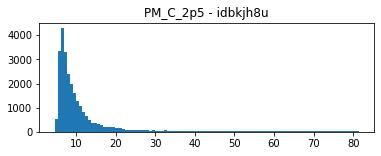

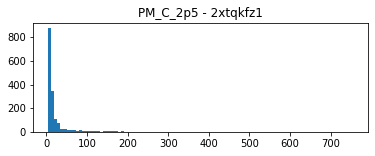

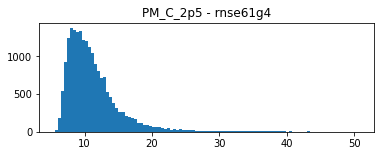

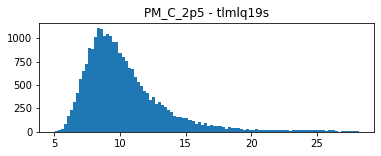

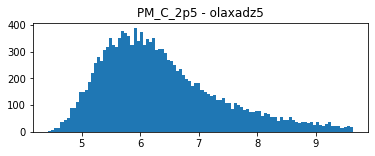

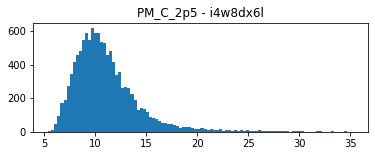

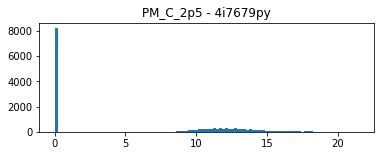

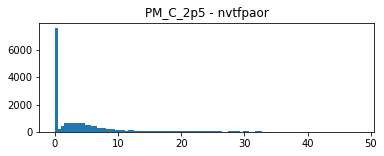

Lux


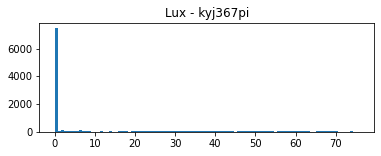

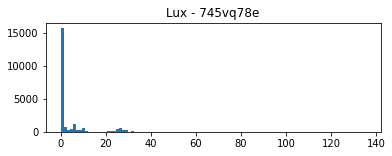

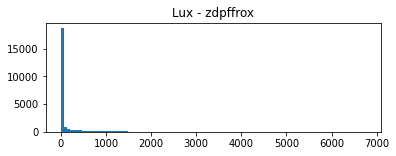

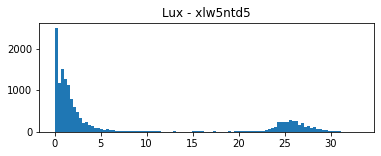

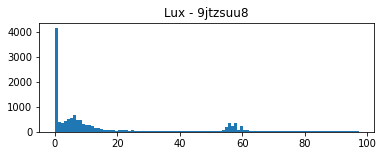

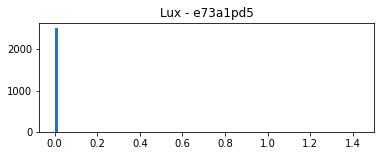

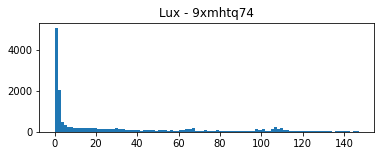

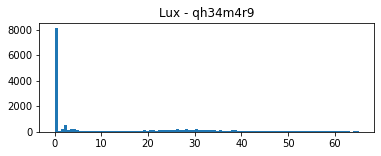

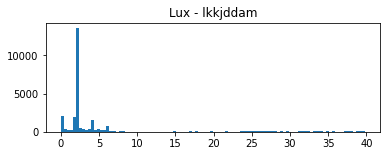

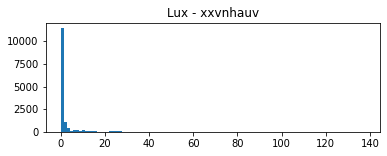

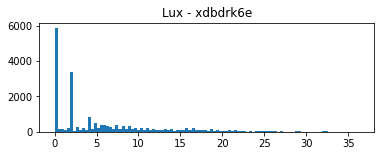

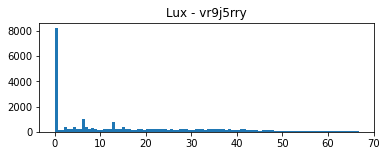

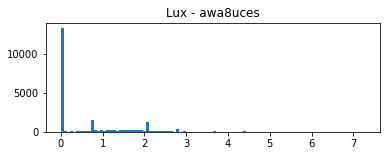

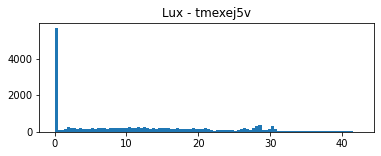

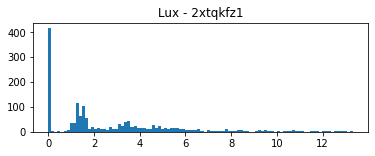

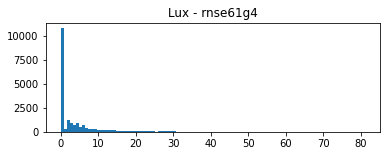

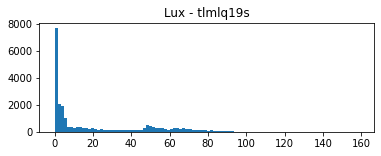

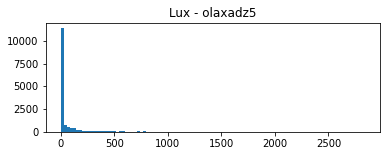

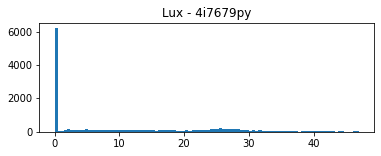

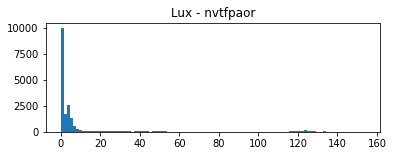

NO2


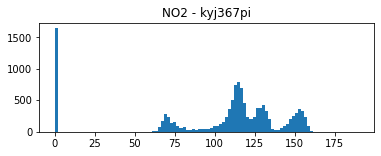

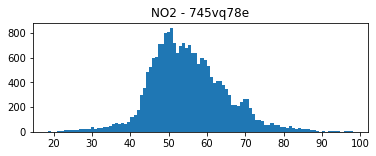

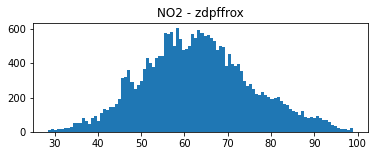

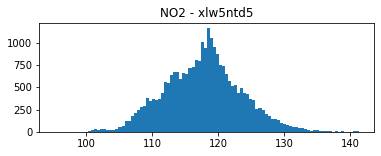

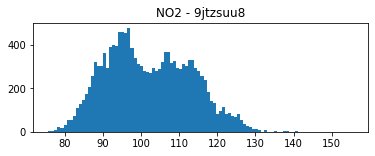

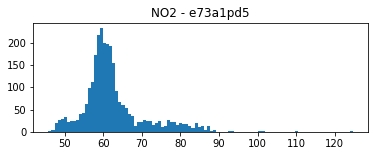

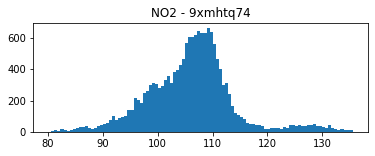

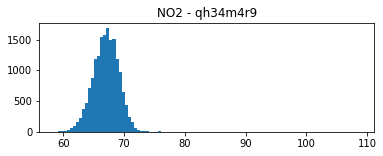

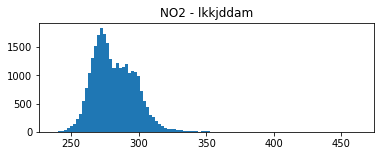

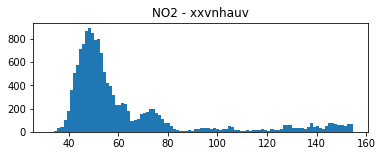

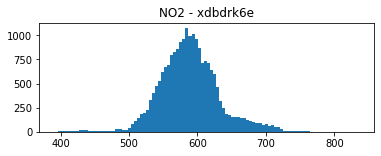

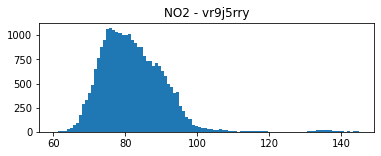

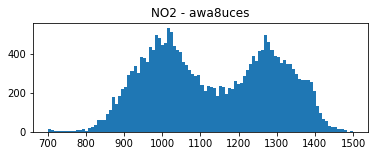

CO


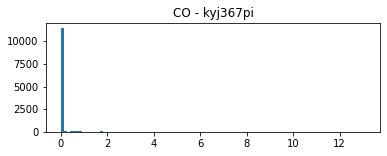

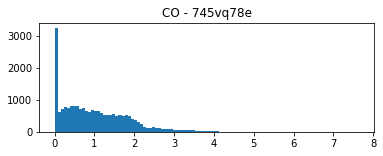

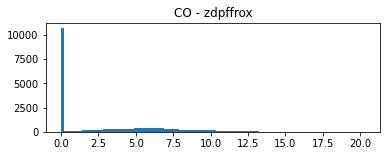

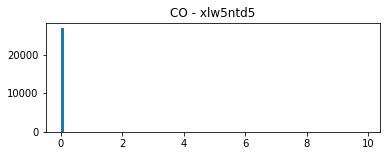

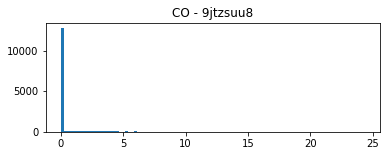

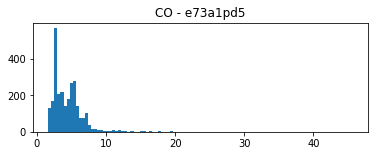

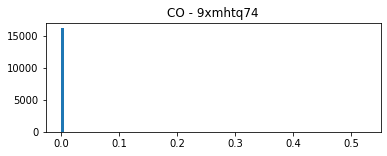

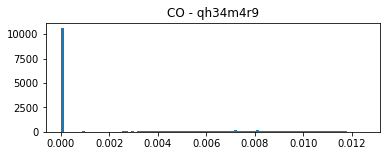

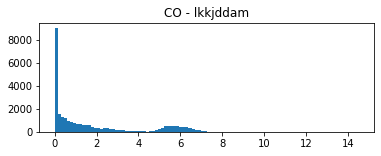

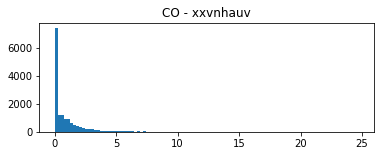

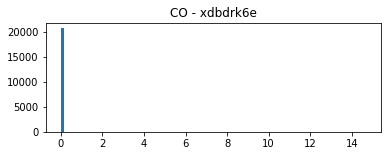

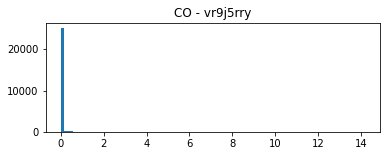

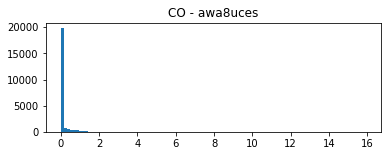

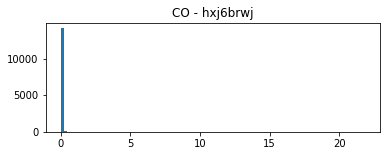

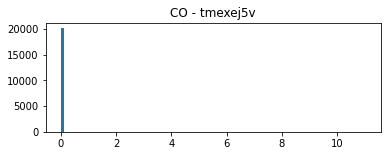

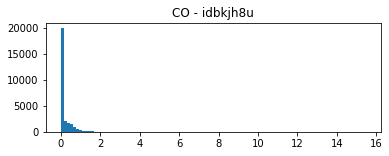

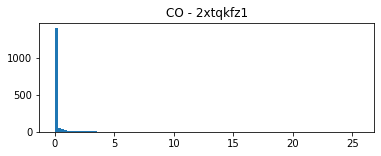

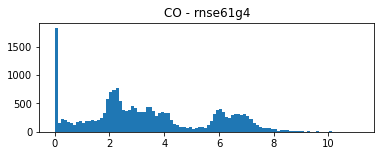

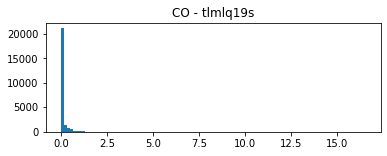

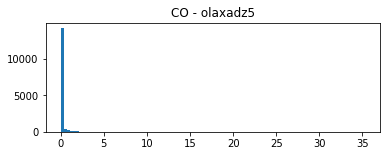

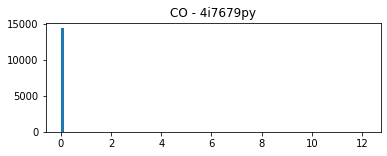

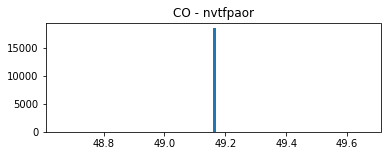

TVOC


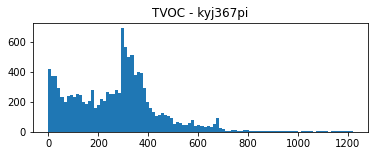

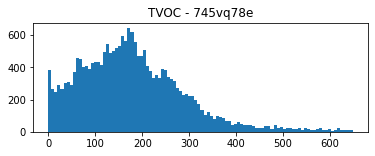

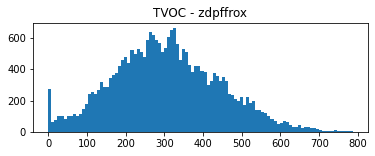

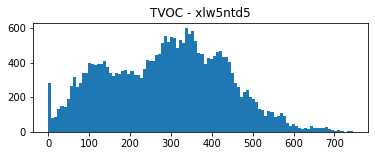

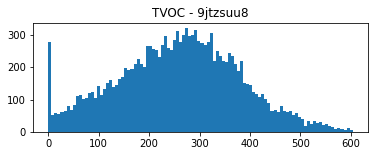

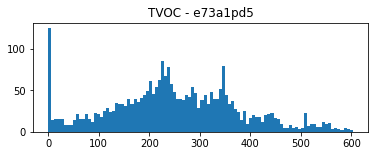

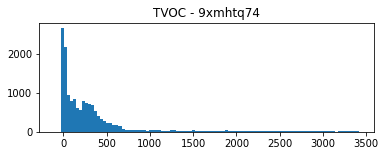

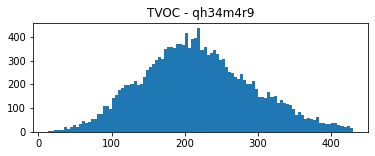

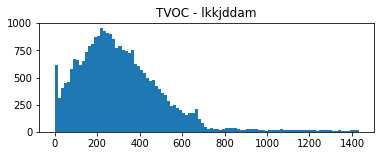

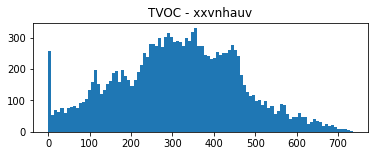

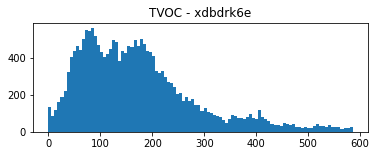

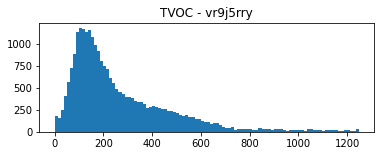

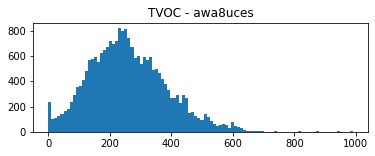

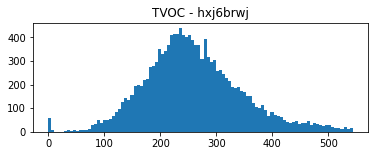

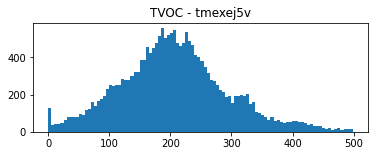

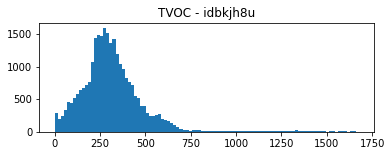

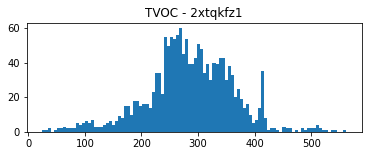

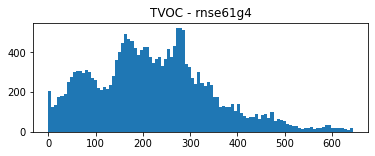

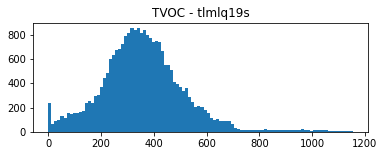

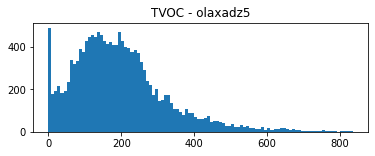

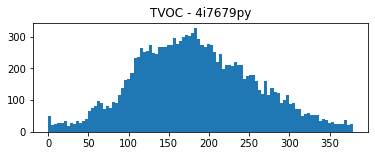

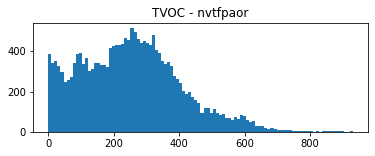

In [14]:
for pollutant in sensors:
    print(pollutant)
    for pt in beacon_data['Beiwe'].unique():
        beacon_pt = beacon_data[beacon_data['Beiwe'] == pt]
        if len(beacon_pt[pollutant].dropna()) > 0:
            fig, ax = plt.subplots(figsize=(6,2))
            ax.hist(beacon_pt[pollutant],bins=100)
            ax.set_title(f'{pollutant} - {pt}')

            plt.show()
            plt.close()

#### Notes
Some thoughts regarding the pre-processing

##### Carbon Dioxide
Shows that pre-processing cannot be done in bulk. Extreme values for one device might not be extreme for another device so each device should be processed separately before combining. 

##### Lux
We need to remove values that are -100 since those correspond to errors.


<div class="alert alert-block alert-success">
    Completed the above notes
</div>

# Example Figures
These figures are meant to give a few examples of the processed data.

In [15]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

#plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
#plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
#plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
#plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## CO2
We want to look at CO2 concentrations over a short time interval from a variety of the participants.

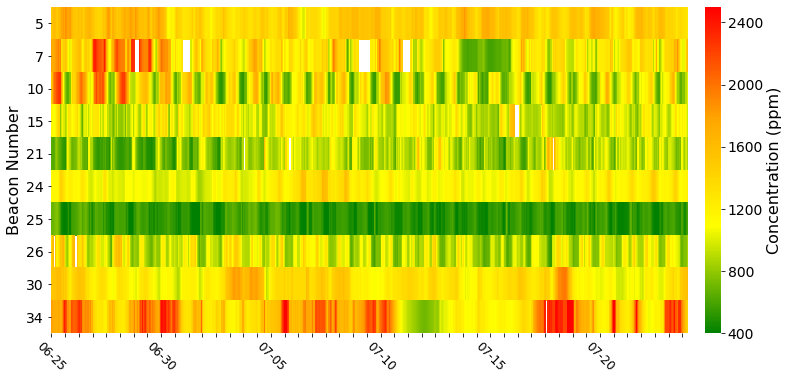

In [16]:
sdate = datetime(2020,6,25)
edate = datetime(2020,7,24)
good_CO2_sensors = [5,7,10,15,21,24,25,26,30,34] # beacon with properly operating CO2 sensors
beacon_CO2 = beacon_data[beacon_data['Beacon'].isin(good_CO2_sensors)]
beacon_CO2 = beacon_CO2[['CO2','Beacon']]
heatmap_df = pd.DataFrame()
for beacon in beacon_CO2['Beacon'].unique():
    df = beacon_CO2[beacon_CO2['Beacon'] == beacon]
    df = df.resample('60T').mean()
    df = df[sdate:edate]
    df.columns = [beacon,'Beacon']
    heatmap_df = heatmap_df.append(df[[beacon]].T)
    
heatmap_df.sort_index(inplace=True)
fig, axes = plt.subplots(1,2,figsize=(12,6),gridspec_kw={'width_ratios': [40, 1]})
sns.heatmap(heatmap_df, vmin=400, vmax=2500, cbar_kws={'ticks':np.arange(400,2800,400),'label':'Concentration (ppm)'}, cmap=create_cmap(["green", "yellow", "orange", "red",],[0.0, 0.33, 0.66, 1]), cbar_ax=axes[1], ax=axes[0])

ax = axes[0]
xlabels = ax.get_xticklabels()
new_xlabels = []
for label in xlabels:
    if label.get_text()[11:13] == "00":
        new_xlabels.append(label.get_text()[5:10])
    else:
        new_xlabels.append('')

ax.set_xticklabels(new_xlabels,rotation=-45)
ax.set_xlabel('')

ax.set_yticklabels(ax.get_yticklabels(),rotation=0)
ax.set_ylabel('Beacon Number')

plt.savefig("../reports/UTx000_COVID/beacon-co2-heatmap-reduced.pdf")
plt.subplots_adjust(wspace=0.05)
plt.show()
plt.close()

# Filtered Data Summary
Borrowing from other research, we can create a table of values for each of the variables measured by the beacon.

In [17]:
beacon_filtered = pd.read_csv('../data/processed/bpeace2-beacon-fb_ema_and_gps_restricted.csv',
                             index_col=0)
beacon_filtered.head()

,Lat,Long,Alt,Accuracy,TVOC,eCO2,Lux,Visible,Infrared,NO2,...,PM_C_1,PM_C_2p5,PM_C_4,PM_C_10,Beacon,Beiwe,Fitbit,REDCap,start_time,end_time
2020-08-10 05:10:00,30.58838,-97.42591,113.98145,5.29684,185.50,750.25,2.04,1.0,0.0,288.95,...,1.747382,6.748117,10.714056,11.507244,21,lkkjddam,25,12,2020-08-10 04:42:30,2020-08-10 12:35:30
2020-08-10 05:15:00,NaN,NaN,NaN,NaN,166.08,706.48,2.04,1.0,0.0,277.12,...,1.753108,6.515844,10.288899,11.043510,21,lkkjddam,25,12,2020-08-10 04:42:30,2020-08-10 12:35:30
2020-08-10 05:20:00,NaN,NaN,NaN,NaN,151.40,666.48,2.04,1.0,0.0,277.44,...,1.696069,6.215933,9.795078,10.510907,21,lkkjddam,25,12,2020-08-10 04:42:30,2020-08-10 12:35:30
2020-08-10 05:25:00,NaN,NaN,NaN,NaN,158.84,686.92,2.04,1.0,0.0,282.44,...,1.609633,6.486098,10.357869,11.132223,21,lkkjddam,25,12,2020-08-10 04:42:30,2020-08-10 12:35:30
2020-08-10 05:30:00,NaN,NaN,NaN,NaN,146.15,669.20,2.04,1.0,0.0,272.80,...,1.660413,6.721101,10.739605,11.543306,21,lkkjddam,25,12,2020-08-10 04:42:30,2020-08-10 12:35:30


Combining T and RH columns from CO and NO2 sensors - averaging where both measured a value and using the single value if only one measured T or RH.

In [18]:
beacon_filtered['T'] = beacon_filtered[['T_CO','T_NO2']].mean(axis=1)
beacon_filtered['RH'] = beacon_filtered[['RH_CO','RH_NO2']].mean(axis=1)

Dropping all unecessary columns

In [19]:
variables = ['Lux','T','RH','TVOC','CO2','CO','NO2','PM_C_1','PM_C_2p5','PM_C_10']
beacon_important = beacon_filtered[variables]
beacon_important.columns

Index(['Lux', 'T', 'RH', 'TVOC', 'CO2', 'CO', 'NO2', 'PM_C_1', 'PM_C_2p5',
       'PM_C_10'],
      dtype='object')

Getting descriptive stats

In [20]:
stats = {'n':[],'avg':[],'med':[],'min':[],'25%':[],'75%':[],'max':[],'skewness':[],'kurtosis':[]}
precision = 2
for variable in variables:
    li = beacon_filtered[variable].dropna().values
    stats['n'].append(len(li))
    stats['avg'].append(round(np.nanmean(li),precision))
    stats['med'].append(round(np.nanmedian(li),precision))
    stats['min'].append(round(np.nanmin(li),precision))
    stats['25%'].append(round(np.nanpercentile(li,25),precision))
    stats['75%'].append(round(np.nanpercentile(li,75),precision))
    stats['max'].append(round(np.nanmax(li),precision))
    stats['skewness'].append(round(scipy.stats.skew(li),precision))
    stats['kurtosis'].append(round(scipy.stats.kurtosis(li),precision))

Creating a stats dataframe and outputting the results

In [21]:
stats_df = pd.DataFrame(data=stats)
stats_df.index = variables
stats_df

,n,avg,med,min,25%,75%,max,skewness,kurtosis
Lux,11332,2.35,0.00,0.0,0.00,0.21,74.91,4.53,25.09
T,12063,26.97,27.00,22.2,25.00,28.50,31.72,-0.07,-0.89
RH,12193,42.58,42.00,30.8,39.56,45.00,62.93,0.78,1.48
TVOC,12054,270.29,241.80,0.0,186.53,332.40,1393.20,1.86,7.27
CO2,11701,951.06,878.73,100.2,734.11,1172.46,2281.53,0.72,0.44
CO,12200,0.58,0.00,0.0,0.00,0.00,13.09,2.95,7.80
NO2,8186,112.52,75.20,0.0,66.44,111.84,646.48,3.58,12.94
PM_C_1,12193,2.97,2.59,0.0,1.76,3.45,72.54,9.52,142.47
PM_C_2p5,12188,7.59,7.19,0.0,5.79,9.00,81.76,4.68,52.33
PM_C_10,12181,11.85,11.42,0.0,9.46,14.13,92.66,2.42,22.43


Formatting the dataframe nicely

In [22]:
beacon_important.columns = ['TVOC','Light','NO$_2$','CO','T','RH','CO$_2$','PM$_1$','PM$_{2.5}$','PM$_{10}$']

Creating a correlation matrix

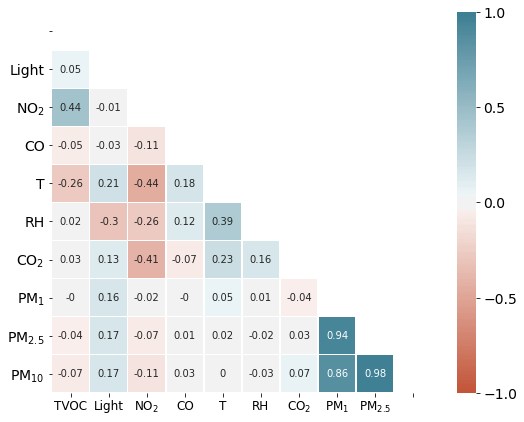

In [23]:
corr = beacon_important.corr()
corr = round(corr,2)
mask = np.triu(np.ones_like(corr, dtype=bool))
fig, ax = plt.subplots(figsize=(9, 7))
sns.heatmap(corr, mask=mask, 
                 vmin=-1, vmax=1, center=0, 
                 cmap=sns.diverging_palette(20, 220, n=200),cbar_kws={'ticks':[-1,-0.5,0,0.5,1]},
                 square=True,linewidths=0.5,annot=True,ax=ax)

yticklabels = ax.get_yticklabels()
yticklabels[0] = ' '
ax.set_yticklabels(yticklabels,rotation=0,ha='right')

xticklabels = ax.get_xticklabels()
xticklabels[-1] = ' '
ax.set_xticklabels(xticklabels,rotation=0,ha='center')

plt.show()
plt.close()

# Filtered Data Completeness
We can also look at how complete the datasets are. There are two ways to summarize the completeness:
1. Percent of possible data collected over the study period i.e. while the participants had their respective devices
2. Percent of possible data collected while the beacon was actually operating. 


## Percent of Possible Data During Study Period
We first need to ensure that we have the correct start and stop periods for each individual. This information is housed in the ```details``` dataframe. 

We want to cross-reference the arrival date of the beacon to the individual and assume that is the start date. The end date can be changed to correspond to Sept. 1st or the return date - whatever happened first.  

In [28]:
details.head()

,REDCap,Beacon,start_date,end_date,move_date,return_date,Lat,Long,Original Address,Volume,Housemates,Roommates,Number of Rooms,original_start,original_end,original_move
Beiwe,,,,,,,,,,,,,,,,
kyj367pi,10,1,2020-06-08 13:00:00,2020-09-03,2020-07-31,2020-09-02,30.312614,-97.732338,"2822 Rio Grande St. Apt 202 Austin, TX, 78705",1080,0,0,1.0,2020-06-15,NaT,2020-09-14
745vq78e,55,5,2020-06-09 10:21:00,2020-08-23,NaT,2020-09-08,30.288012,-97.751201,"18207 Branson Falls San Antonio, TX 78255",1188,0,0,5.0,2020-06-15,NaT,2020-08-17
itmylz3g,61,6,2020-06-17 14:08:00,2020-09-01,NaT,2020-09-01,29.855371,-95.741200,"5403 Dunsmore Harbor Ln, Katy, TX 77449",1188,0,0,5.0,2020-06-15,2020-09-11,2020-07-03
zdpffrox,0,7,2020-06-01 00:00:00,2020-09-01,NaT,2020-09-01,30.326815,-97.744665,"2211 Lawnmont Avenue apt 314 Austin, TX 78756",1365,1,1,NaN,2020-06-06,2020-09-03,2020-07-31
xlw5ntd5,43,10,2020-06-08 13:19:00,2020-09-11,2020-08-10,2020-09-22,30.351693,-97.614524,"6704 bramber ln, austin, tx 78754",1188,0,0,NaN,2020-06-08,NaT,2020-07-01


In [30]:
beacon_data

,TVOC,eCO2,Lux,Visible,Infrared,NO2,T_NO2,RH_NO2,CO,T_CO,...,PM_N_4,PM_N_10,PM_C_1,PM_C_2p5,PM_C_4,PM_C_10,Beacon,Beiwe,Fitbit,REDCap
Timestamp,,,,,,,,,,,,,,,,,,,,,
2020-06-13 20:00:00,537.88,990.12,0.0,0.0,0.0,74.64,28.0,36.80,0.0,28.0,...,39.961129,40.164481,4.925515,11.135812,15.932873,16.892285,1,kyj367pi,24,10
2020-06-13 20:05:00,537.70,1006.65,0.0,0.0,0.0,75.85,28.0,37.00,0.0,28.0,...,32.546536,32.691019,4.020243,8.442126,11.833886,12.512238,1,kyj367pi,24,10
2020-06-13 20:10:00,537.64,1020.24,0.0,0.0,0.0,76.56,28.0,37.00,0.0,28.0,...,34.809603,34.927838,4.314605,7.951792,10.694790,11.243390,1,kyj367pi,24,10
2020-06-13 20:15:00,542.40,1080.52,0.0,0.0,0.0,74.52,28.0,36.28,0.0,28.0,...,40.619122,40.779581,5.025503,9.946487,13.695432,14.445220,1,kyj367pi,24,10
2020-06-13 20:20:00,541.04,1093.04,0.0,0.0,0.0,74.92,28.0,36.40,0.0,28.0,...,37.065600,37.242149,4.573548,9.970680,14.125998,14.957063,1,kyj367pi,24,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-26 23:40:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,46,nvtfpaor,7,33
2020-08-26 23:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,46,nvtfpaor,7,33
2020-08-26 23:50:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,46,nvtfpaor,7,33


In [65]:
variables = ['Beacon','Lux','TVOC','CO2','CO','NO2','PM_C_1','PM_C_2p5','PM_C_10']
beacon_df = beacon_data[variables]

max_n = 0
max_n_no2 = 0
for bb in beacon_df['Beacon'].unique():
    beacon_pt = beacon_df[beacon_df['Beacon'] == bb]
    starting_date = pd.to_datetime(details[details['Beacon'] == bb]['start_date'].values[0])
    ending_date = pd.to_datetime(details[details['Beacon'] == bb]['end_date'].values[0])
    if ending_date > datetime(2020,9,1):
        ending_date = datetime(2020,9,1)
        
    max_n += (ending_date - starting_date).total_seconds()/60/5
    # Add no2 count
    if beacon_pt['NO2'].count() == 0:
        print(f'{bb}: no NO2 data')
    else:
        print(f'{bb}: has NO2 data')

1: has NO2 data
5: has NO2 data
6: no NO2 data
7: has NO2 data
10: has NO2 data
11: no NO2 data
15: has NO2 data
16: has NO2 data
17: has NO2 data
19: has NO2 data
21: has NO2 data
22: has NO2 data
24: has NO2 data
25: has NO2 data
26: has NO2 data
28: no NO2 data
29: no NO2 data
30: no NO2 data
32: no NO2 data
34: no NO2 data
36: no NO2 data
38: no NO2 data
40: no NO2 data
44: no NO2 data
46: no NO2 data
